# Phone cost prediction 
<br>
Author: Presnyakov Oleg
<br>
Course Project, UC Irvine, Math 10, S24
<br>
I would like to post my notebook on the course’s website. Yes

## Introduction:
In this project I am aimimg to build a model that will predict a price for a phone using it's features. 
<br>
The data was taken from a relatively new dataset on kaggle: <br>
https://www.kaggle.com/datasets/dewangmoghe/mobile-phone-price-prediction/data

## Importing and setting up the data

In [303]:
import pandas as pd
import altair as alt
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
from sklearn.impute import SimpleImputer

In [304]:
df = pd.read_csv("/Users/olegpresnyakov/Desktop/prediction.csv")
df.head(5)

,Unnamed: 0,Name,Rating,Spec_score,No_of_sim,Ram,Battery,Display,Camera,External_Memory,Android_version,Price,company,Inbuilt_memory,fast_charging,Screen_resolution,Processor,Processor_name
0,0,Samsung Galaxy F14 5G,4.65,68,"Dual Sim, 3G, 4G, 5G, VoLTE,",4 GB RAM,6000 mAh Battery,6.6 inches,50 MP + 2 MP Dual Rear &amp; 13 MP Front Camera,"Memory Card Supported, upto 1 TB",13,"9,999",Samsung,128 GB inbuilt,25W Fast Charging,2408 x 1080 px Display with Water Drop Notch,Octa Core Processor,Exynos 1330
1,1,Samsung Galaxy A11,4.20,63,"Dual Sim, 3G, 4G, VoLTE,",2 GB RAM,4000 mAh Battery,6.4 inches,13 MP + 5 MP + 2 MP Triple Rear &amp; 8 MP Fro...,"Memory Card Supported, upto 512 GB",10,"9,990",Samsung,32 GB inbuilt,15W Fast Charging,720 x 1560 px Display with Punch Hole,1.8 GHz Processor,Octa Core
2,2,Samsung Galaxy A13,4.30,75,"Dual Sim, 3G, 4G, VoLTE,",4 GB RAM,5000 mAh Battery,6.6 inches,50 MP Quad Rear &amp; 8 MP Front Camera,"Memory Card Supported, upto 1 TB",12,"11,999",Samsung,64 GB inbuilt,25W Fast Charging,1080 x 2408 px Display with Water Drop Notch,2 GHz Processor,Octa Core
3,3,Samsung Galaxy F23,4.10,73,"Dual Sim, 3G, 4G, VoLTE,",4 GB RAM,6000 mAh Battery,6.4 inches,48 MP Quad Rear &amp; 13 MP Front Camera,"Memory Card Supported, upto 1 TB",12,"11,999",Samsung,64 GB inbuilt,NaN,720 x 1600 px,Octa Core,Helio G88
4,4,Samsung Galaxy A03s (4GB RAM + 64GB),4.10,69,"Dual Sim, 3G, 4G, VoLTE,",4 GB RAM,5000 mAh Battery,6.5 inches,13 MP + 2 MP + 2 MP Triple Rear &amp; 5 MP Fro...,"Memory Card Supported, upto 1 TB",11,"11,999",Samsung,64 GB inbuilt,15W Fast Charging,720 x 1600 px Display with Water Drop Notch,Octa Core,Helio P35


At first let's look at all mising values that we have in our data and try to figure out how we can fill them in. While finding solution for that problem, we also want to clear data to numerical, that will allows us to apply numerical algorithms on data

In [305]:
df.isnull().values.any()

True

In [306]:
columns_with_missing_values = df.columns[df.isnull().any()]
print("Columns with missing values:")
print(columns_with_missing_values)

Columns with missing values:
Index(['Android_version', 'Inbuilt_memory', 'fast_charging',
       'Screen_resolution', 'Processor'],
      dtype='object')


In [307]:
df['Ram'] = df['Ram'].str.extract('(\d+)').astype(float)
df['Battery'] = df['Battery'].str.extract('(\d+)').astype(float)
df['Display'] = df['Display'].str.extract('(\d+.\d+)').astype(float)
df['Price'] = df['Price'].str.replace(',', '').astype(float)
df['fast_charging'] = df['fast_charging'].str.extract('(\d+)').astype(float)

In [308]:
df['fast_charging'].fillna('0', inplace=True)
df['Rating'].fillna(df['Rating'].median(), inplace=True)
df['Spec_score'].fillna(df['Spec_score'].median(), inplace=True)
df['Ram'].fillna(df['Ram'].median(), inplace=True)
df['Battery'].fillna(df['Battery'].median(), inplace=True)
df['Display'].fillna(df['Display'].median(), inplace=True)
df['Price'].fillna(df['Price'].median(), inplace=True)

## Working with a memory representation and screen resolution

In [309]:
df['EXT_Memory_GB'] = df['External_Memory'].str.extract(r'(\d+)').astype(float)
df['Unit'] = df['External_Memory'].str.extract(r'(\w+)$')

conversion_factors = {'TB': 1024, 'GB': 1}
df['EXT_Memory_GB'] *= df['Unit'].map(conversion_factors)
df.drop(columns=['External_Memory', 'Unit'], inplace=True)

In [310]:
df['Memory_GB'] = df['Inbuilt_memory'].str.extract(r'(\d+)').astype(float)
df['Unit'] = df['Inbuilt_memory'].str.extract(r'(\w+)$')
df.loc[df['Unit'] == 'TB', 'Memory_GB'] *= 1024
df.drop(columns=['Unit'], inplace=True)

In [311]:
df[['px', 'Feature']] = df['Screen_resolution'].str.extract(r'(\d+ x \d+) px Display with (Water Drop Notch|Punch Hole)')
df['Display with Water Drop Notch'] = df['Feature'].apply(lambda x: 1 if x == 'Water Drop Notch' else 0)
df['Display with Punch Hole'] = df['Feature'].apply(lambda x: 1 if x == 'Punch Hole' else 0)
df.drop(columns=['Screen_resolution', 'Feature'], inplace=True)
df['No_of_sim_count'] = df['No_of_sim'].str.count(',') + 1
df.drop(columns=['No_of_sim'], inplace=True)

In [312]:
df.head()

,Unnamed: 0,Name,Rating,Spec_score,Ram,Battery,Display,Camera,Android_version,Price,...,Inbuilt_memory,fast_charging,Processor,Processor_name,EXT_Memory_GB,Memory_GB,px,Display with Water Drop Notch,Display with Punch Hole,No_of_sim_count
0,0,Samsung Galaxy F14 5G,4.65,68,4.0,6000.0,6.6,50 MP + 2 MP Dual Rear &amp; 13 MP Front Camera,13,9999.0,...,128 GB inbuilt,25.0,Octa Core Processor,Exynos 1330,1024.0,128.0,2408 x 1080,1,0,6
1,1,Samsung Galaxy A11,4.20,63,2.0,4000.0,6.4,13 MP + 5 MP + 2 MP Triple Rear &amp; 8 MP Fro...,10,9990.0,...,32 GB inbuilt,15.0,1.8 GHz Processor,Octa Core,512.0,32.0,720 x 1560,0,1,5
2,2,Samsung Galaxy A13,4.30,75,4.0,5000.0,6.6,50 MP Quad Rear &amp; 8 MP Front Camera,12,11999.0,...,64 GB inbuilt,25.0,2 GHz Processor,Octa Core,1024.0,64.0,1080 x 2408,1,0,5
3,3,Samsung Galaxy F23,4.10,73,4.0,6000.0,6.4,48 MP Quad Rear &amp; 13 MP Front Camera,12,11999.0,...,64 GB inbuilt,0,Octa Core,Helio G88,1024.0,64.0,NaN,0,0,5
4,4,Samsung Galaxy A03s (4GB RAM + 64GB),4.10,69,4.0,5000.0,6.5,13 MP + 2 MP + 2 MP Triple Rear &amp; 5 MP Fro...,11,11999.0,...,64 GB inbuilt,15.0,Octa Core,Helio P35,1024.0,64.0,720 x 1600,1,0,5


## Working with camera

In [313]:
def sum_megapixels(camera_str):
    rear_megapixels = sum(map(int, re.findall(r'(\d+)\s*MP', camera_str.split('&')[0])))
    if len(camera_str.split('&')) > 1:
        front_megapixels = sum(map(int, re.findall(r'(\d+)\s*MP', camera_str.split('&')[1])))
    else:
        front_megapixels = 0
    return rear_megapixels, front_megapixels

df['Rear'], df['Front'] = zip(*df['Camera'].apply(sum_megapixels))
df.drop(columns=['Camera'], inplace=True)

In [314]:
def resolution_to_product(resolution_str):
    if isinstance(resolution_str, str):
        parts = resolution_str.split('x')
        if len(parts) == 2:
            try:
                width = int(parts[0])
                height = int(parts[1])
                return width * height
            except ValueError:
                return None
        else:
            return None
    elif isinstance(resolution_str, int):
        return resolution_str
    else:
        return None

df['px'] = df['px'].apply(resolution_to_product)

In [315]:
df.head()

,Unnamed: 0,Name,Rating,Spec_score,Ram,Battery,Display,Android_version,Price,company,...,Processor,Processor_name,EXT_Memory_GB,Memory_GB,px,Display with Water Drop Notch,Display with Punch Hole,No_of_sim_count,Rear,Front
0,0,Samsung Galaxy F14 5G,4.65,68,4.0,6000.0,6.6,13,9999.0,Samsung,...,Octa Core Processor,Exynos 1330,1024.0,128.0,2600640.0,1,0,6,52,13
1,1,Samsung Galaxy A11,4.20,63,2.0,4000.0,6.4,10,9990.0,Samsung,...,1.8 GHz Processor,Octa Core,512.0,32.0,1123200.0,0,1,5,20,8
2,2,Samsung Galaxy A13,4.30,75,4.0,5000.0,6.6,12,11999.0,Samsung,...,2 GHz Processor,Octa Core,1024.0,64.0,2600640.0,1,0,5,50,8
3,3,Samsung Galaxy F23,4.10,73,4.0,6000.0,6.4,12,11999.0,Samsung,...,Octa Core,Helio G88,1024.0,64.0,NaN,0,0,5,48,13
4,4,Samsung Galaxy A03s (4GB RAM + 64GB),4.10,69,4.0,5000.0,6.5,11,11999.0,Samsung,...,Octa Core,Helio P35,1024.0,64.0,1152000.0,1,0,5,17,5


In [316]:
columns_for_dummies = ['company', 'Processor', 'Processor_name']
dummy_variables = pd.get_dummies(df[columns_for_dummies])
df_with_dummies = pd.concat([df, dummy_variables], axis=1)
df_with_dummies.drop(columns_for_dummies, axis=1, inplace=True)
df = df_with_dummies

df.head()

,Unnamed: 0,Name,Rating,Spec_score,Ram,Battery,Display,Android_version,Price,Inbuilt_memory,...,Processor_name_Tiger T616,Processor_name_Unisoc SC9836A,Processor_name_Unisoc SC9863A,Processor_name_Unisoc T606,Processor_name_Unisoc SC9832E,Processor_name_Unisoc SC9863A,Processor_name_Unisoc T603,Processor_name_Unisoc T606,Processor_name_Unisoc T610,Processor_name_Unisoc T612
0,0,Samsung Galaxy F14 5G,4.65,68,4.0,6000.0,6.6,13,9999.0,128 GB inbuilt,...,0,0,0,0,0,0,0,0,0,0
1,1,Samsung Galaxy A11,4.20,63,2.0,4000.0,6.4,10,9990.0,32 GB inbuilt,...,0,0,0,0,0,0,0,0,0,0
2,2,Samsung Galaxy A13,4.30,75,4.0,5000.0,6.6,12,11999.0,64 GB inbuilt,...,0,0,0,0,0,0,0,0,0,0
3,3,Samsung Galaxy F23,4.10,73,4.0,6000.0,6.4,12,11999.0,64 GB inbuilt,...,0,0,0,0,0,0,0,0,0,0
4,4,Samsung Galaxy A03s (4GB RAM + 64GB),4.10,69,4.0,5000.0,6.5,11,11999.0,64 GB inbuilt,...,0,0,0,0,0,0,0,0,0,0


Now let's finally apply algorithms to predict price for a phone:

#### Simple linear regression

Train RMSE: 10665.29
Test RMSE: 203643.32
Train R^2: 0.88
Test R^2: -45.00


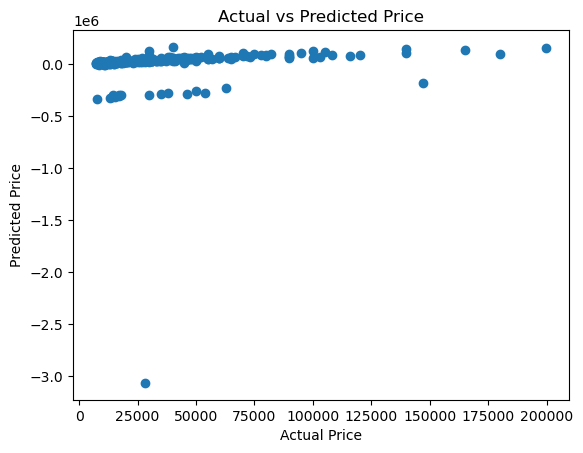

In [317]:
numeric_cols = df.select_dtypes(include=['number']).columns
df_numeric = df[numeric_cols]

imputer = SimpleImputer(strategy='mean')
df_imputed = pd.DataFrame(imputer.fit_transform(df_numeric), columns=df_numeric.columns)

X = df_imputed.drop(columns=['Price'])
y = df_imputed['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

train_rmse = mean_squared_error(y_train, model.predict(X_train), squared=False)
test_rmse = mean_squared_error(y_test, model.predict(X_test), squared=False)
r2_train = r2_score(y_train, model.predict(X_train))
r2_test = r2_score(y_test, model.predict(X_test))

print(f'Train RMSE: {train_rmse:.2f}')
print(f'Test RMSE: {test_rmse:.2f}')
print(f'Train R^2: {r2_train:.2f}')
print(f'Test R^2: {r2_test:.2f}')

y_pred = model.predict(X_test)
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Price')
plt.show()

#### Simple linear regression with KFold

Mean Train R^2: 0.01
Mean Test R^2: 0.01


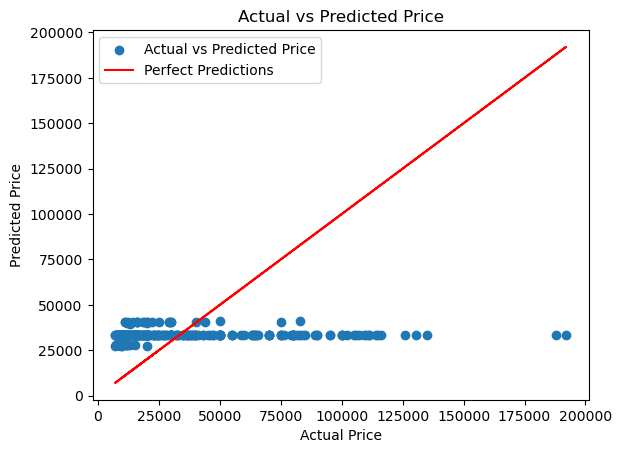

In [318]:
numeric_cols = df.select_dtypes(include=['number']).columns
df_numeric = df[numeric_cols]

imputer = SimpleImputer(strategy='mean')
df_imputed = pd.DataFrame(imputer.fit_transform(df_numeric), columns=df_numeric.columns)

y = df_imputed['Price']

kf = KFold(n_splits=5, shuffle=True, random_state=42)
train_r2_scores = []
test_r2_scores = []

for train_index, test_index in kf.split(X_pca):
    X_train, X_test = X_pca[train_index], X_pca[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    train_r2_scores.append(r2_score(y_train, model.predict(X_train)))
    test_r2_scores.append(r2_score(y_test, model.predict(X_test)))

mean_train_r2 = np.mean(train_r2_scores)
mean_test_r2 = np.mean(test_r2_scores)

print(f'Mean Train R^2: {mean_train_r2:.2f}')
print(f'Mean Test R^2: {mean_test_r2:.2f}')
plt.scatter(y_test, model.predict(X_test), label='Actual vs Predicted Price')
plt.plot(y_test, y_test, color='red', label='Perfect Predictions')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Price')
plt.legend()
plt.show()

Notice that the model that was constructed using linear regression is very bad in terms of mean R^2. We can only explain 1% of the data using this method. This is why, lets try to implement more advanced structure on the dataset.

#### Random forest

In [319]:
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train_imputed, y_train)

train_r2 = r2_score(y_train, model.predict(X_train_imputed))
test_r2 = r2_score(y_test, model.predict(X_test_imputed))

print(f'Train R^2: {train_r2:.2f}')
print(f'Test R^2: {test_r2:.2f}')


Train R^2: 0.86
Test R^2: 0.12


#### Random forest using KFold 

Mean Train R^2: 0.98
Mean Test R^2: 0.83


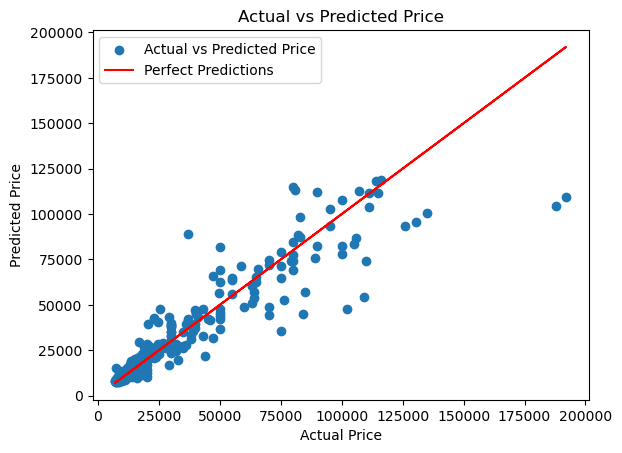

In [320]:
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

model = RandomForestRegressor(n_estimators=100, random_state=42)

kf = KFold(n_splits=5, shuffle=True, random_state=42)
train_r2_scores = []
test_r2_scores = []

for train_index, test_index in kf.split(X_imputed):
    X_train, X_test = X_imputed[train_index], X_imputed[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    model.fit(X_train, y_train)
    
    train_r2_scores.append(r2_score(y_train, model.predict(X_train)))
    test_r2_scores.append(r2_score(y_test, model.predict(X_test)))

mean_train_r2 = np.mean(train_r2_scores)
mean_test_r2 = np.mean(test_r2_scores)

print(f'Mean Train R^2: {mean_train_r2:.2f}')
print(f'Mean Test R^2: {mean_test_r2:.2f}')

plt.scatter(y_test, model.predict(X_test), label='Actual vs Predicted Price')
plt.plot(y_test, y_test, color='red', label='Perfect Predictions')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Price')
plt.legend()
plt.show()

## Summary
We tackled the challenge of predicting smartphone prices using machine learning. Leveraging a dataset with key features, our algorithm, a Random Forest regressor with K-Fold cross-validation, showed promising results in accurately predicting prices. This approach sheds light on pricing dynamics and underscores the potential of data-driven decision-making in the smartphone industry.